In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.estimator import LinearClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(tf.__version__)

2.1.0


In [2]:
col_names = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
target_dimensions = ['Setosa', 'Versicolor', 'Virginica']

training_data_path = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_data_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

training = pd.read_csv(training_data_path, names=col_names, header=0)
training = training[training['Species'] >= 1]
training['Species'] = training['Species'].replace([1,2], [0,1])
test = pd.read_csv(test_data_path, names=col_names, header=0)
test = test[test['Species'] >= 1]
test['Species'] = test['Species'].replace([1,2], [0,1])

training.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

iris_dataset = pd.concat([training, test], axis=0)

In [3]:
iris_dataset.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000,0.500000
std,0.662834,0.332751,0.825578,0.424769,0.502519
min,4.900000,2.000000,3.000000,1.000000,0.000000
25%,5.800000,2.700000,4.375000,1.300000,0.000000
50%,6.300000,2.900000,4.900000,1.600000,0.500000
75%,6.700000,3.025000,5.525000,2.000000,1.000000
max,7.900000,3.800000,6.900000,2.500000,1.000000


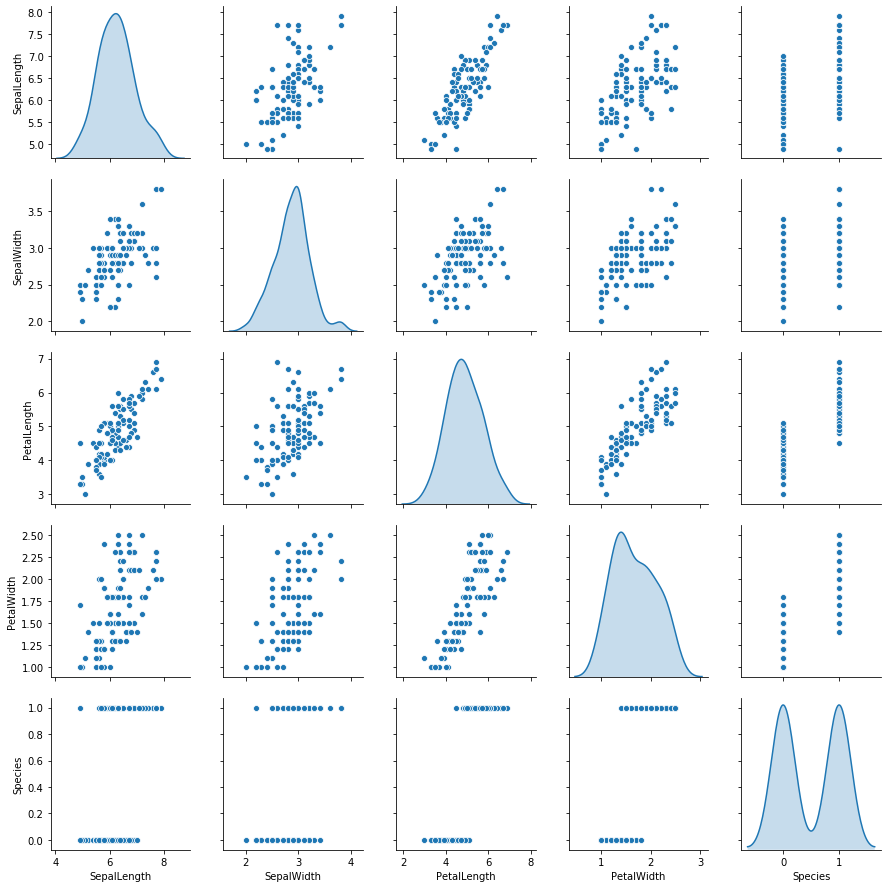

In [4]:
sb.pairplot(iris_dataset, diag_kind="kde")

In [5]:
correlation_data = iris_dataset.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
SepalLength,1,0.553855,0.828479,0.593709,0.494305
SepalWidth,0.553855,1,0.519802,0.566203,0.30808
PetalLength,0.828479,0.519802,1,0.823348,0.786424
PetalWidth,0.593709,0.566203,0.823348,1,0.828129
Species,0.494305,0.30808,0.786424,0.828129,1


In [6]:
stats = iris_dataset.describe()
iris_stats = stats.transpose()
iris_stats

,count,mean,std,min,25%,50%,75%,max
SepalLength,100.0,6.262,0.662834,4.9,5.800,6.3,6.700,7.9
SepalWidth,100.0,2.872,0.332751,2.0,2.700,2.9,3.025,3.8
PetalLength,100.0,4.906,0.825578,3.0,4.375,4.9,5.525,6.9
PetalWidth,100.0,1.676,0.424769,1.0,1.300,1.6,2.000,2.5
Species,100.0,0.500,0.502519,0.0,0.000,0.5,1.000,1.0


In [7]:
X_data = iris_dataset[[m for m in iris_dataset.columns if m not in ['Species']]]
Y_data = iris_dataset[['Species']]

## Train Test Split

In [8]:
training_features , test_features ,training_labels, test_labels = train_test_split(X_data , Y_data , test_size=0.2)

In [9]:
print('No. of rows in Training Features: ', training_features.shape[0])
print('No. of rows in Test Features: ', test_features.shape[0])
print('No. of columns in Training Features: ', training_features.shape[1])
print('No. of columns in Test Features: ', test_features.shape[1])

print('No. of rows in Training Label: ', training_labels.shape[0])
print('No. of rows in Test Label: ', test_labels.shape[0])
print('No. of columns in Training Label: ', training_labels.shape[1])
print('No. of columns in Test Label: ', test_labels.shape[1])

No. of rows in Training Features:  80
No. of rows in Test Features:  20
No. of columns in Training Features:  4
No. of columns in Test Features:  4
No. of rows in Training Label:  80
No. of rows in Test Label:  20
No. of columns in Training Label:  1
No. of columns in Test Label:  1


In [10]:
stats = training_features.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
SepalLength,80.0,6.24625,0.680830,4.9,5.775,6.30,6.700,7.9
SepalWidth,80.0,2.87375,0.357822,2.0,2.600,2.95,3.100,3.8
PetalLength,80.0,4.88625,0.834804,3.0,4.300,4.90,5.525,6.9
PetalWidth,80.0,1.69375,0.434972,1.0,1.300,1.65,2.000,2.5


In [11]:
stats = test_features.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
SepalLength,20.0,6.325,0.597252,5.5,5.95,6.20,6.575,7.6
SepalWidth,20.0,2.865,0.210950,2.4,2.80,2.80,2.925,3.4
PetalLength,20.0,4.985,0.803463,3.7,4.50,4.75,5.525,6.6
PetalWidth,20.0,1.605,0.383165,1.0,1.30,1.50,1.825,2.3


## Normalize Data

In [12]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose()
  return (x - stats['mean']) / stats['std']

normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

## Build the Input Pipeline for TensorFlow model

In [13]:
def feed_input(features_dataframe, target_dataframe, num_of_epochs=10, shuffle=True, batch_size=32):
  def input_feed_function():
    dataset = tf.data.Dataset.from_tensor_slices((dict(features_dataframe), target_dataframe))
    if shuffle:
      dataset = dataset.shuffle(2000)
    dataset = dataset.batch(batch_size).repeat(num_of_epochs)
    return dataset
  return input_feed_function

train_feed_input = feed_input(normed_train_features, training_labels)
train_feed_input_testing = feed_input(normed_train_features, training_labels, num_of_epochs=1, shuffle=False)
test_feed_input = feed_input(normed_test_features, test_labels, num_of_epochs=1, shuffle=False)

## Model Training

In [14]:
feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]

In [15]:
logistic_model = LinearClassifier(feature_columns=feature_columns_numeric)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpf61n0ijp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
logistic_model.train(train_feed_input)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorf

## Predictions

In [17]:
train_predictions = logistic_model.predict(train_feed_input_testing)
test_predictions = logistic_model.predict(test_feed_input)

In [18]:
train_predictions_series = pd.Series([p['classes'][0].decode("utf-8")   for p in train_predictions])
test_predictions_series = pd.Series([p['classes'][0].decode("utf-8")   for p in test_predictions])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpf61n0ijp/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all l

In [19]:
train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])

In [20]:
training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)

test_labels.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)

In [21]:
train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels, test_predictions_df], axis=1)

## Validation

In [22]:
def calculate_binary_class_scores(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred.astype('int64'))
  precision = precision_score(y_true, y_pred.astype('int64'))
  recall = recall_score(y_true, y_pred.astype('int64'))
  return accuracy, precision, recall



In [23]:
train_accuracy_score, train_precision_score, train_recall_score = calculate_binary_class_scores(training_labels, train_predictions_series)
test_accuracy_score, test_precision_score, test_recall_score = calculate_binary_class_scores(test_labels, test_predictions_series)

print('Training Data Accuracy (%) = ', round(train_accuracy_score*100,2))
print('Training Data Precision (%) = ', round(train_precision_score*100,2))
print('Training Data Recall (%) = ', round(train_recall_score*100,2))
print('-'*50)
print('Test Data Accuracy (%) = ', round(test_accuracy_score*100,2))
print('Test Data Precision (%) = ', round(test_precision_score*100,2))
print('Test Data Recall (%) = ', round(test_recall_score*100,2))


Training Data Accuracy (%) =  95.0
Training Data Precision (%) =  95.12
Training Data Recall (%) =  95.12
--------------------------------------------------
Test Data Accuracy (%) =  95.0
Test Data Precision (%) =  100.0
Test Data Recall (%) =  88.89
